## TensorFlow Installation
**TensorFlow works on windows environments which only meeting these requirements:**<br/>
* 64-bit, x86 desktops or laptops
* Windows 7 or later<br/>



**This project use TensorFlow with CPU support**<br/>
#### Installing with Anaconda
1. Follow the instructions on the [Anaconda download](https://www.anaconda.com/download/) site to download and install Anaconda.
2. Create a conda environment named tensorflow by invoking the following command:
```
C:> conda create -n tensorflow pip python=3.5 
```
3. Activate the conda environment by issuing the following command:
```
C:> activate tensorflow
 (tensorflow)C:>  # Your prompt should change 
```
4. Issue the appropriate command to install TensorFlow inside your conda environment. To install the CPU-only version of TensorFlow, enter the following command:
```
(tensorflow)C:> pip install --ignore-installed --upgrade tensorflow
```

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import LabelEncoder
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Predifine size of input images **

In [2]:
training_path='./dataset_merged/training'
validation_path='./dataset_merged/validation'
img_h = 224
img_w = 224

**Read image files and labels from local directory. Then one-hot encode the labels.**<br/>
**Use a one-hot encoding on categorical data.<br/>**
<p>For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.<p/>
<p>In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).<p/>

In [3]:
def load_data(path):
    directories = [d for d in os.listdir(path) 
                       if os.path.isdir(os.path.join(path, d))]
    imgs=[]
    labels=[]
    for d in directories:
        label_directory = os.path.join(training_path, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".jpg")]
        for f in file_names:
            imgs.append(f)
            labels.append(d)
    # One_hot encode the labels
    LE=LabelEncoder()
    labels=LE.fit_transform(labels)
    labels=np.eye(7)[np.array([labels]).reshape(-1)]
    return imgs,labels

**Load training set and validation set.**<br/>
<p>Differences and connections between training set, validation set and testing set:<p/>
* Validation set is a part of training set.
* Both validations et and traning set are labeled.
* Testing set is the set without labels.

In [5]:
train_imgs,train_labels=load_data(training_path)
test_imgs,test_labels=load_data(validation_path)

**Define hyperparameters**
<p>Learning Rate: Learning is one used to update gradient and between 0.01 to 0.001.<p/>
<p>Epoch: Epoch is the times your data go over the whole model. If you have epoch 10, inputs will go over the whole model for 10 times.<p/>
<p>Batch siza: Total number of training examples present in a single batch.<p/>

In [6]:
learning_rate = 0.0001
epochs = 2
batch_size = 32

**This method is to decode image files and labels into tensors in order to be fed into tensorflow session.**

In [7]:
from tensorflow.python.framework import ops

def read_data(imgs,labels):
    image_path_tf = ops.convert_to_tensor(imgs, dtype=tf.string, name="image_paths_tf")
    labels_tf = ops.convert_to_tensor(labels, dtype=tf.int32, name="labels_tf")
    image_name_tf, label_tf = tf.train.slice_input_producer([image_path_tf, labels_tf],shuffle=True)
    image_buffer_tf = tf.read_file(image_name_tf, name="image_buffer")
    image = tf.image.decode_jpeg(image_buffer_tf, channels=3)    
    global img_h,img_w
    # Resize the images
    image = tf.image.resize_image_with_crop_or_pad(image, img_h, img_w)
    
    # Cast types to float32
    return tf.cast(image,tf.float32),tf.cast(label_tf,tf.float32)

**Call read_data() and decode the train and test set**

In [8]:
train_imgs_tf, train_labels_tf=read_data(train_imgs, train_labels)
test_imgs_tf, test_labels_tf=read_data(test_imgs, test_labels)

**Create shuffle batch for train and test set**
<p>Test data willbe size 500.<p/>

In [9]:
num_preprocess_threads = 3
min_queue_examples = 3 * batch_size

train_data = tf.train.shuffle_batch(
    [train_imgs_tf, train_labels_tf],
    batch_size=batch_size,
    num_threads=num_preprocess_threads,
    capacity=min_queue_examples + 3 * batch_size,
    min_after_dequeue=min_queue_examples,
    name="train_images")

# Test data will be size 500.
test_data = tf.train.shuffle_batch(
    [test_imgs_tf, test_labels_tf],
    batch_size=500,
    num_threads=num_preprocess_threads,
    capacity=min_queue_examples + 1 * batch_size,
    min_after_dequeue=min_queue_examples,
    name="test_images")

print('Batch shape: ', train_data[0].shape)     # This is the shape of input into neural network.
print('Label shape: ', train_data[1].shape)     # This is the shaoe of output that we want.

Batch shape:  (32, 224, 224, 3)
Label shape:  (32, 7)


**Declare the training data placeholders**
<p>Placeholders:<p/>
Placeholders are used to feed data from outside the model.

In [9]:
x = tf.placeholder(tf.float32, [None,img_w,img_h,3],name='raw_input')
y = tf.placeholder(tf.float32, [None, 7], name='output')

# Add input images into summary, it will be written into tensorboard in a running tf.session.
tf.summary.image('input_img', x)

**Building conv layer**
<p>Setup the filter input shape for conv layer<p/>
<p>Initialise weights and bias for the filter<p/>
<p>Setup the convolutional layer operation<p/>
<p>Apply a ReLU non-linear activation<p/>
<p>Add these parameters into summary<p/>

In [10]:
from tensorflow.python.framework.dtypes import float32


def conv(input, in_shape, out_shape, filter_shape, name='conv'):
    with tf.name_scope(name):   # To clean the tensorflow graph
        
        # setup the filter input shape for conv layer
        conv_filt_shape = [filter_shape[0], filter_shape[1], in_shape, out_shape]
    
        # initialise weights and bias for the filter
        weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.3), name=name+'_w')
        bias = tf.Variable(tf.constant(0.1,shape=[out_shape]), name=name+'_b')
    
        # setup the convolutional layer operation
        _ = tf.nn.conv2d(input, weights, [1, 1, 1, 1], padding='SAME')      
        
        # apply a ReLU non-linear activation
        act=tf.nn.relu(_+bias)
        
        # Add these parameters into summary
        tf.summary.histogram('weights',weights)
        tf.summary.histogram('bias',bias)
        tf.summary.histogram('actications',act)
         
        return act

**Building fully connected layer**

In [11]:

def fc(input, in_shape, out_shape, name='conv'):
    with tf.name_scope(name):
        
        # They're all initialized with zeros
        weights = tf.Variable(tf.zeros([in_shape, out_shape]), name=name+'_w')
        bias = tf.Variable(tf.zeros([out_shape]), name=name+'_b')      
        return tf.matmul(input, weights)+bias

**Build a simple CNN using the method defined before**
<p>This neural network contains 2 conv-pooling structures and 2 fully connected layers.<p/>

In [12]:
# First conv layer
conv1 = conv(x, 3, 32, [5, 5],name='conv1')
pool1= tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding='SAME', name='pool1')
tf.summary.image('conv1_output',tf.expand_dims(pool1[:,:,:,0],axis=-1),max_outputs=3)

# Second conv layer
conv2 = conv(pool1, 32, 64, [5, 5],name='conv2')
pool2= tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding='SAME', name='pool2')

# Flattern the output of conv layers
flattened = tf.reshape(pool2, [-1, 56 * 56 * 64])

# Go through 2 fc layers
fc1 = fc(flattened, 56*56*64, 1000, name='fc1')
fc2 = fc(fc1, 1000, 7, name='fc2')

**Define metrics and optimizer**
<p>Loss Function:<p/>
We use sigmoid here to calculate loss. 
   <p>Sigmoid:<p/>
    <p>Sigmoid returns value from 0 to -1.<p/>
<br/>
<p>Optimizer:</p>
<p>The goal of optimization is to find W that minimizes the loss function. We will now motivate and slowly develop an approach to optimizing the loss function.<p/>


In [13]:
# Define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fc2, labels=y),name='loss')
tf.summary.scalar('loss', loss)

# add an optimizer
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate,name='optmz').minimize(loss)

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='acc')
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

**Test block 1. To check the output of pool1 layer.**

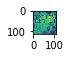

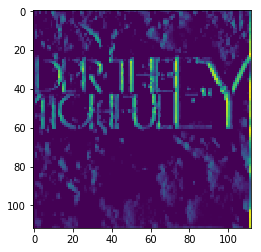

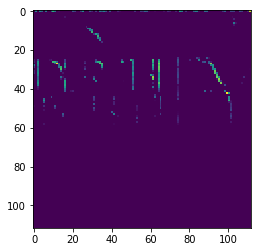

In [14]:
init_op = (tf.global_variables_initializer(), tf.local_variables_initializer())


with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Get output of pool1
    out=sess.run(pool1,feed_dict={x:train_data[0].eval(), y:train_data[1].eval()})
    fig=plt.figure(figsize=(8, 4))
    
    for i in range(3):
        fig.add_subplot(8, 4, i+1)
        plt.imshow(out[0,:,:,i])
        plt.show()
    
    coord.request_stop()
    coord.join(threads)

**Test block 2. To check the output of pool2 layer.**

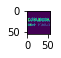

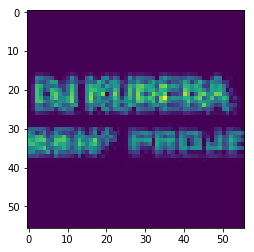

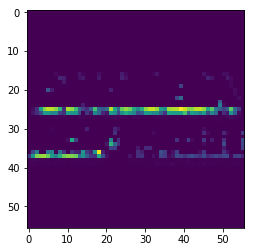

In [15]:
init_op = (tf.global_variables_initializer(), tf.local_variables_initializer())


with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Get output of pool2
    out=sess.run(pool2,feed_dict={x:train_data[0].eval(), y:train_data[1].eval()})
    fig=plt.figure(figsize=(8, 4))
    
    for i in range(3):
        fig.add_subplot(8, 4, i+1)
        plt.imshow(out[0,:,:,i])
        plt.show()
    
    coord.request_stop()
    coord.join(threads)

**Train the network.**

In [15]:
# setup the initialisation operator
init_op = (tf.global_variables_initializer(), tf.local_variables_initializer())

merged_summary=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Set writer to write summaries into tensorboard
    writer=tf.summary.FileWriter('./Graph/genre_classfication_crossentropy_try5', graph=sess.graph)
    
    print('Training started...')
    for epoch in range(epochs):
        print('Epoch: ',(epoch+1))
        avg_cost=0
        total_batch=int(7622/batch_size)
        
        for i in range(total_batch):
            sess.run(optimizer, feed_dict={x:train_data[0].eval(), y:train_data[1].eval()})      
            
            if i%20==0:
                l,s, acc= sess.run([loss,merged_summary,accuracy], feed_dict={x:train_data[0].eval(), y:train_data[1].eval()})
                writer.add_summary(s,epoch*total_batch+i)
                print('Step: ',i, ' loss: ', l, 'train accuracy: ', acc)
                avg_cost += l/total_batch*20
                
        print("\nEpoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))

    print("\nTraining complete!")
    
    coord.request_stop()
    coord.join(threads)

Training started...
Epoch:  1
Step:  0  loss:  0.6931471 train accuracy:  0.34375
Step:  20  loss:  0.6931468 train accuracy:  0.25
Step:  40  loss:  0.69314635 train accuracy:  0.21875
Step:  60  loss:  0.69314617 train accuracy:  0.25
Step:  80  loss:  0.6931459 train accuracy:  0.21875
Step:  100  loss:  0.69314545 train accuracy:  0.1875
Step:  120  loss:  0.6931449 train accuracy:  0.46875
Step:  140  loss:  0.6931448 train accuracy:  0.21875
Step:  160  loss:  0.6931444 train accuracy:  0.28125
Step:  180  loss:  0.6931439 train accuracy:  0.4375
Step:  200  loss:  0.6931434 train accuracy:  0.40625
Step:  220  loss:  0.6931433 train accuracy:  0.21875

Epoch: 1 cost = 0.000
Epoch:  2
Step:  0  loss:  0.6931428 train accuracy:  0.34375
Step:  20  loss:  0.6931424 train accuracy:  0.28125
Step:  40  loss:  0.69314194 train accuracy:  0.40625
Step:  60  loss:  0.6931418 train accuracy:  0.28125
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.error

KeyboardInterrupt: 

**Next we're going to do transfer learning using the pretrained Inception_V3 model.**
<p>STEPS<p/>
1. load inception_v3 model, keep the pretrained weights and remove top layers.
2. Create layer dictionary of layers in the model

In [10]:
# load inception_v3 model, keep the pretrained weights and remove top layers.
incp3=tf.keras.applications.InceptionV3(include_top=False,
                                        weights='imagenet',
                                        input_shape=(img_w,img_h,3),
                                        classes=7)

In [11]:
# Create layer dictionary of layers in the model
layer_dict = dict([(layer.name, layer) for layer in incp3.layers[1:]])

**Define metrics and optimizer.**
<p> Add customized top layers for inception model<p/>
<p> The output of the truncated inception model is (batch_size,5,5,2048)<p/>
<p> Let's add a global max pooling layer on top of it, which can be implemented in tensorflow as below. Then flatten it.<p/>

In [12]:
targets=tf.placeholder(dtype=tf.float32,shape=[None,7],name='targets')

# Add customized top layers for inception model
# The output of the truncated inception model is (batch_size,5,5,2048)
# Let's add a global max pooling layer on top of it, which can be implemented in tensorflow as below. Then flatten it.
top_dense=tf.layers.flatten(tf.layers.max_pooling2d(incp3.outputs[0],(5,5),(5,5),padding='valid'))

# Put the flattened tensor through a dence layer to get a 1-D vector of length 7, which is also the prediction of our model.
predictions=tf.layers.dense(top_dense,7)

# Define loss function
loss_incp3=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions,labels=targets))

# Define optimizer
optimizer_incp3=tf.train.AdadeltaOptimizer().minimize(loss_incp3)

# Define accuracies
train_acc_incp3=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(targets,1)),dtype=tf.float32),name='incp3_acc')
test_acc_incp3=tf.reduce_mean(tf.cast(tf.equal(
                                        tf.argmax(predictions,1),
                                        tf.argmax(targets,1)), 
                                        dtype=tf.float32),  name='test_acc')

In [13]:
# Define all summaries we want to write into tensorboard

tf.summary.scalar('loss',loss_incp3)
tf.summary.scalar('acc',train_acc_incp3)

# Visualize output of all mixed layers
tf.summary.image('raw_input',incp3.input)
for i in range(9):
    layer_name='mixed'+str(i+1)
    tf.summary.image(name=layer_name+'_output',tensor=tf.expand_dims(layer_dict[layer_name].output[:,:,:,0],axis=-1))
    
# Merge all summaries above
merged_summary=tf.summary.merge_all()

**Training the Inception model.**<br/>
<p>Steps to open tensorboard:<p/>
	1. Type in
```
tensorboard --logdir ./Genre_classification
```
    in a terminal or CMD<br/>
	2. Open up a browser and go to 'localhost:6006'

In [ ]:
# Initialize graph
init_op = (tf.global_variables_initializer(), tf.local_variables_initializer())


with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Setup a filewriter
    writer=tf.summary.FileWriter('./Genre_classification/try_7_fix_some_issues', graph=sess.graph)
    
    print('Training started...')
    
    # Each epoch
    for epoch in range(epochs):
        print('Epoch: ',(epoch+1))
        avg_cost=0
        total_batch=int(7622/batch_size)
        
        # Each step
        for i in range(total_batch):
            # Run optimizer
            sess.run(optimizer_incp3, 
                     feed_dict={incp3.input:train_data[0].eval(), targets:train_data[1].eval()})      
            
            # write summary every 10 steps
            if i%10==0:
                l,s, acc= sess.run([loss_incp3,merged_summary,train_acc_incp3], 
                                   feed_dict={incp3.input:train_data[0].eval(), targets:train_data[1].eval()})
                writer.add_summary(s,epoch*total_batch+i)
                print('Step: ',i, ' loss: ', l, ' train accuracy: ', acc)
        
        # Test on test set after each epoch 
        writer.add_summary(sess.run(tf.summary.scalar('test_acc', test_acc_incp3),
                                    feed_dict={incp3.input:test_data[0].eval(), targets:test_data[1].eval()}))
        print("\nEpoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
        
    print("\nTraining complete!")
    
    coord.request_stop()
    coord.join(threads)

In [ ]:
incp3.save('./saved_model.h5')

# License
This project is licensed under the MIT License - see the file [LICENSE.md](https://github.com/qiuminzhang/discogs_scrapy/blob/master/LICENSE) for details

# Citation
This project uses licensed open source python framework Scrapy - see the file [LICENSE.md](https://github.com/scrapy/scrapy/blob/master/LICENSE) for details.

For keras built-in Inception_v3 model, please refer to this https://keras.io/applications/#inceptionv3